### ENV Setup

In [1]:
!pip install pandas scikit-learn sentence-transformers tqdm

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install numpy==1.24.4 pandas==2.1.4


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
faiss-cpu 1.10.0 requires numpy<3.0,>=1.25.0, but you have numpy 1.24.4 which is incompatible.


In [3]:
!pip install nltk

In [4]:
!pip install faiss-cpu

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
^C
ERROR: Operation cancelled by user


In [44]:
!pip install stanza

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 49.2 MB/s eta 0:00:00


In [5]:
!pip install pybind11>=2.12

In [ ]:
!pip install razdel

### Embeddings comparison

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import ast
from tqdm import tqdm
import numpy as np
from razdel import sentenize

mapping_df = pd.read_csv("ru_to_uk_mapping.csv")
ru_df = pd.read_csv("wikipedia/extended_fork.csv")
uk_df = pd.read_csv("wikipedia/uk_before.csv")
ruw_df = pd.read_csv("wikipedia/ru_before.csv")

ru_df = ru_df[ru_df['page_title'].isin(mapping_df['ru_title']) & (ru_df['label'] == 1)]
uk_df = uk_df[uk_df['page_title'].isin(mapping_df['uk_title'])]
ruw_df = ruw_df[ruw_df['page_title'].isin(mapping_df['ru_title'])]

uk_df = uk_df.merge(mapping_df, left_on='page_title', right_on='uk_title')
ruw_df = ruw_df.merge(mapping_df, left_on='page_title', right_on='ru_title')

def flatten_changes(change_str):
    try:
        tuples = ast.literal_eval(change_str)
        return " ".join([f"{old} -> {new}" for old, new in tuples])
    except:
        return ""

ru_texts = []
ru_titles = []

for title, group in tqdm(ru_df.groupby('page_title'), desc="Processing RU titles"):
    full_text = " ".join(group['text'].fillna("").astype(str).tolist())
    sentences = [s.text.strip() for s in sentenize(full_text) if len(s.text.strip()) > 10]
    for sent in sentences:
        ru_titles.append(title)
        ru_texts.append(sent)

uk_segments = []
uk_info = []

for _, row in tqdm(uk_df.iterrows(), total=len(uk_df), desc="Processing UK rows"):
    title = row['uk_title']
    for kind, text in {
        "insert": row['texts_insert'],
        "remove": row['texts_removed'],
        "change": flatten_changes(row['texts_change'])
    }.items():
        if pd.isna(text) or len(str(text).strip()) < 10:
            continue
        uk_segments.append(str(text).strip())
        uk_info.append({
            'uk_title': title,
            'segment_type': kind,
            'user': row['user'],
            'timestamp': row['event_timestamp'],
            'is_reverted': row['is_reverted']
        })

ruw_segments = []
ruw_info = []

for _, row in tqdm(ruw_df.iterrows(), total=len(ruw_df), desc="Processing RUW rows"):
    title = row['ru_title']
    for kind, text in {
        "insert": row['texts_insert'],
        "remove": row['texts_removed'],
        "change": flatten_changes(row['texts_change'])
    }.items():
        if pd.isna(text) or len(str(text).strip()) < 10:
            continue
        ruw_segments.append(str(text).strip())
        ruw_info.append({
            'ruw_title': title,
            'segment_type': kind,
            'user': row['user'],
            'timestamp': row['event_timestamp'],
            'is_reverted': row['is_reverted']
        })

model = SentenceTransformer('sentence-transformers/LaBSE')

ru_embeddings = model.encode(ru_texts, show_progress_bar=True)
uk_embeddings = model.encode(uk_segments, show_progress_bar=True)
ruw_embeddings = model.encode(ruw_segments, show_progress_bar=True)

ru_emb_df = pd.DataFrame({'page_title': ru_titles, 'text': ru_texts})
ru_emb_df.to_parquet("ru_embeddings.parquet")
np.save("ru_embeddings.npy", ru_embeddings)

uk_emb_df = pd.DataFrame(uk_info)
uk_emb_df['text'] = uk_segments
uk_emb_df.to_parquet("uk_embeddings.parquet")
np.save("uk_embeddings.npy", uk_embeddings)

ruw_emb_df = pd.DataFrame(ruw_info)
ruw_emb_df['text'] = ruw_segments
ruw_emb_df.to_parquet("ruw_embeddings.parquet")
np.save("ruw_embeddings.npy", ruw_embeddings)


Processing RUW rows: 100%|██████████| 24310/24310 [00:01<00:00, 15305.36it/s]


Batches:   0%|          | 0/367 [00:00<?, ?it/s]

Batches:   0%|          | 0/333 [00:00<?, ?it/s]

Batches:   0%|          | 0/1020 [00:00<?, ?it/s]

In [104]:
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm

ru_emb_df = pd.read_parquet("ru_embeddings.parquet")
uk_emb_df = pd.read_parquet("uk_embeddings.parquet")
ruw_emb_df = pd.read_parquet("ruw_embeddings.parquet")


ru_raw = np.load("ru_embeddings.npy", allow_pickle=True)
uk_raw = np.load("uk_embeddings.npy", allow_pickle=True)
ruw_raw = np.load("ruw_embeddings.npy", allow_pickle=True)


ru_embeddings = np.stack(ru_raw).astype('float32')
uk_embeddings = np.stack(uk_raw).astype('float32')
ruw_embeddings = np.stack(ruw_raw).astype('float32')

faiss.normalize_L2(ru_embeddings)
index = faiss.IndexFlatIP(ru_embeddings.shape[1])
index.add(ru_embeddings)


threshold = 0.8
top_k = 3


# RFork --- UW matches
uk_results = []
for i in tqdm(range(len(uk_embeddings)), desc="Matching UK to RU"):
    uk_emb = uk_embeddings[i].reshape(1, -1).astype('float32')
    faiss.normalize_L2(uk_emb)
    D, I = index.search(uk_emb, k=top_k)

    for j in range(top_k):
        sim = D[0][j]
        ru_idx = I[0][j]
        if sim >= threshold:
            uk_results.append({
                "source": "UK",
                "uk_title": uk_emb_df.iloc[i]['uk_title'],
                "segment_type": uk_emb_df.iloc[i]['segment_type'],
                "user": uk_emb_df.iloc[i]['user'],
                "timestamp": uk_emb_df.iloc[i]['timestamp'],
                "uk_text": uk_emb_df.iloc[i]['text'],
                "ru_text": ru_emb_df.iloc[ru_idx]['text'],
                "ru_title": ru_emb_df.iloc[ru_idx]['page_title'],
                "similarity": float(sim),
                "is_reverted": uk_emb_df.iloc[i]['is_reverted']
            })

# RFork --- RW matches
ruw_results = []
for i in tqdm(range(len(ruw_embeddings)), desc="Matching RUW to RU"):
    ruw_emb = ruw_embeddings[i].reshape(1, -1).astype('float32')
    faiss.normalize_L2(ruw_emb)
    D, I = index.search(ruw_emb, k=top_k)

    for j in range(top_k):
        sim = D[0][j]
        ru_idx = I[0][j]
        if sim >= threshold:
            ruw_results.append({
                "source": "RUW",
                "ruw_title": ruw_emb_df.iloc[i]['ruw_title'],
                "segment_type": ruw_emb_df.iloc[i]['segment_type'],
                "user": ruw_emb_df.iloc[i]['user'],
                "timestamp": ruw_emb_df.iloc[i]['timestamp'],
                "ruw_text": ruw_emb_df.iloc[i]['text'],
                "ru_text": ru_emb_df.iloc[ru_idx]['text'],
                "ru_title": ru_emb_df.iloc[ru_idx]['page_title'],
                "similarity": float(sim),
                "is_reverted": ruw_emb_df.iloc[i]['is_reverted']
            })

pd.DataFrame(uk_results).to_csv("uk_ru_high_similarity_matches.csv", index=False)
pd.DataFrame(ruw_results).to_csv("ruw_ru_high_similarity_matches.csv", index=False)

Matching RUW to RU: 100%|██████████| 32626/32626 [01:03<00:00, 513.58it/s]


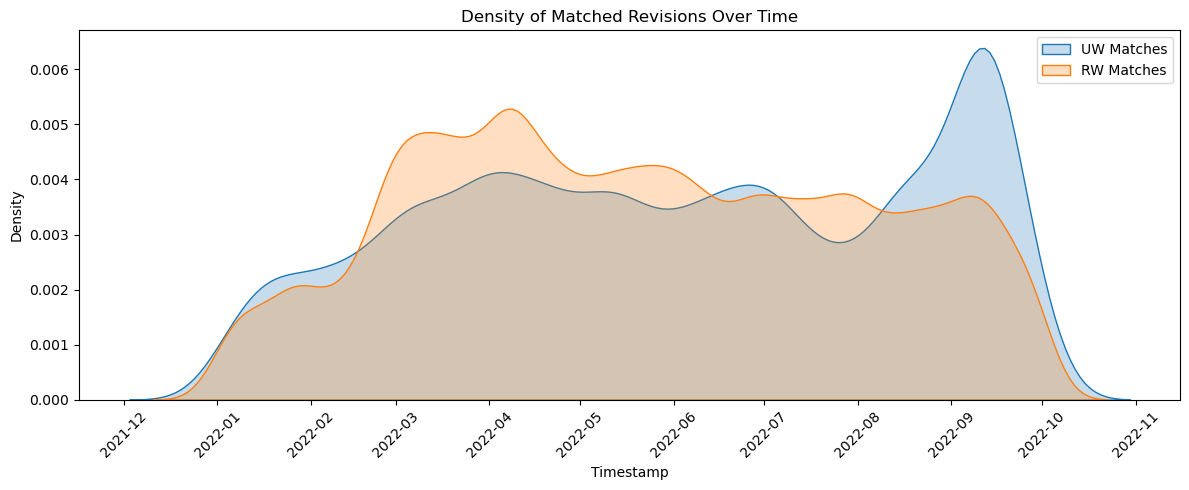

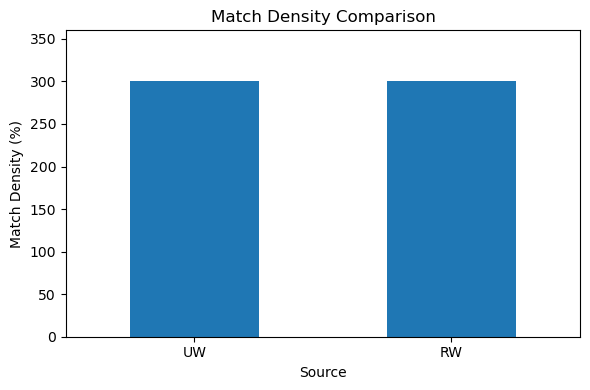

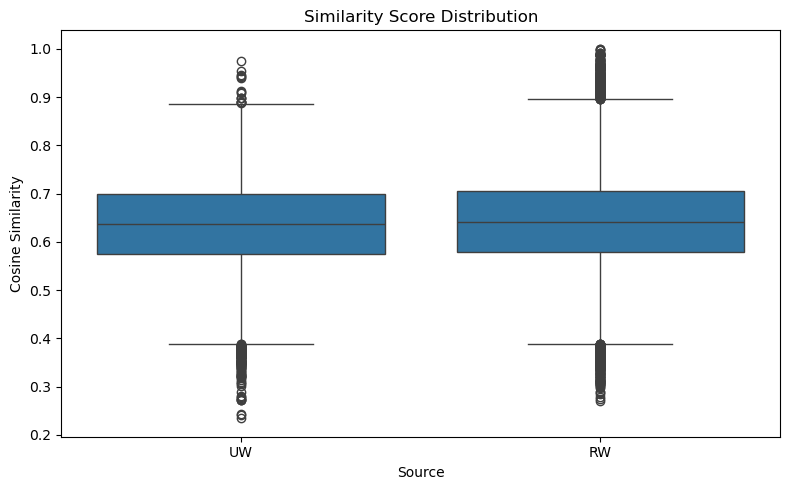

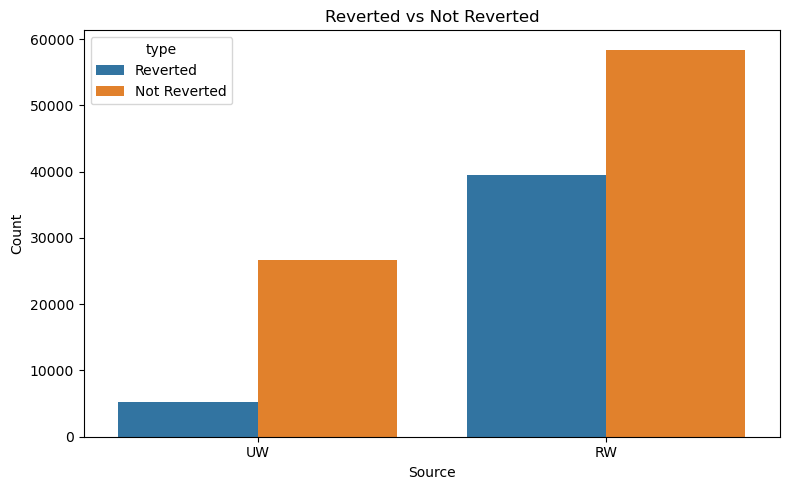

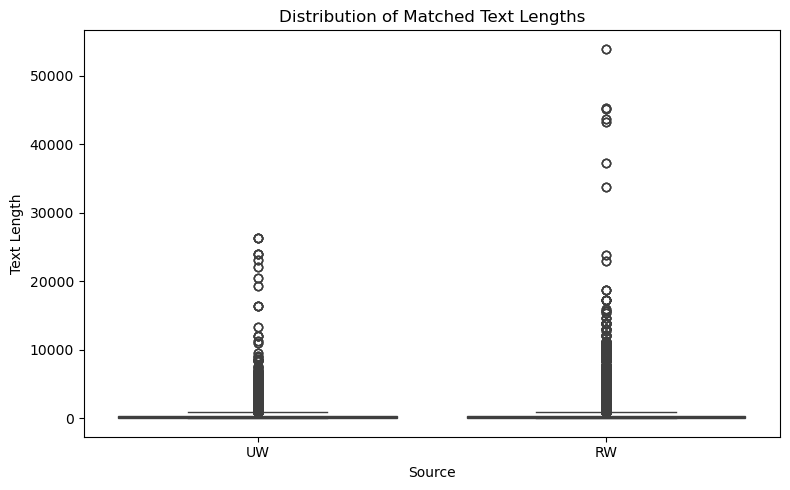

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


uk_df = pd.read_csv("uk_ru_high_similarity_matches.csv")
ruw_df = pd.read_csv("ruw_ru_high_similarity_matches.csv")

total_uk = len(pd.read_parquet("uk_embeddings.parquet"))
total_ruw = len(pd.read_parquet("ruw_embeddings.parquet"))

matched_uk = len(uk_df)
matched_ruw = len(ruw_df)

uk_reverted_counts = uk_df['is_reverted'].value_counts().to_dict()
ruw_reverted_counts = ruw_df['is_reverted'].value_counts().to_dict()

uk_df['timestamp'] = pd.to_datetime(uk_df['timestamp'], errors='coerce')
ruw_df['timestamp'] = pd.to_datetime(ruw_df['timestamp'], errors='coerce')

plt.figure(figsize=(12, 5))
sns.kdeplot(uk_df['timestamp'], label='UW Matches', fill=True)
sns.kdeplot(ruw_df['timestamp'], label='RW Matches', fill=True)
plt.title("Density of Matched Revisions Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Density")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("timestamp_density.pdf")
plt.show()
plt.close()

match_density = pd.DataFrame({
    "Source": ["UW", "RW"],
    "Total Records": [total_uk, total_ruw],
    "Matched Records": [matched_uk, matched_ruw],
    "Match Density (%)": [matched_uk / total_uk * 100, matched_ruw / total_ruw * 100]
})

ax = match_density.set_index("Source")[["Match Density (%)"]].plot(
    kind="bar", legend=False, figsize=(6, 4), ylim=(0, 1.2 * max(match_density["Match Density (%)"]))
)
plt.title("Match Density Comparison")
plt.ylabel("Match Density (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("match_density_bar.pdf")
plt.show()
plt.close()

uk_df["source"] = "UW"
ruw_df["source"] = "RW"
combined = pd.concat([uk_df[["similarity", "source"]], ruw_df[["similarity", "source"]]])

plt.figure(figsize=(8, 5))
sns.boxplot(data=combined, x="source", y="similarity")
plt.title("Similarity Score Distribution")
plt.ylabel("Cosine Similarity")
plt.xlabel("Source")
plt.tight_layout()
plt.savefig("similarity_boxplot.pdf")
plt.show()
plt.close()

revert_comparison = pd.DataFrame([
    {"source": "UW", "type": "Reverted", "count": uk_reverted_counts.get(1, 0)},
    {"source": "UW", "type": "Not Reverted", "count": uk_reverted_counts.get(0, 0)},
    {"source": "RW", "type": "Reverted", "count": ruw_reverted_counts.get(1, 0)},
    {"source": "RW", "type": "Not Reverted", "count": ruw_reverted_counts.get(0, 0)},
])

plt.figure(figsize=(8, 5))
sns.barplot(data=revert_comparison, x="source", y="count", hue="type")
plt.title("Reverted vs Not Reverted")
plt.ylabel("Count")
plt.xlabel("Source")
plt.tight_layout()
plt.savefig("revert_status_bar.pdf")
plt.show()
plt.close()

uk_df['text_length'] = uk_df['uk_text'].str.len()
ruw_df['text_length'] = ruw_df['ruw_text'].str.len()

text_lengths = pd.concat([
    uk_df[['source', 'text_length']],
    ruw_df[['source', 'text_length']]
])

plt.figure(figsize=(8, 5))
sns.boxplot(data=text_lengths, x='source', y='text_length')
plt.title('Distribution of Matched Text Lengths')
plt.xlabel('Source')
plt.ylabel('Text Length')
plt.tight_layout()
plt.savefig("text_length_boxplot.pdf")
plt.show()
plt.close()

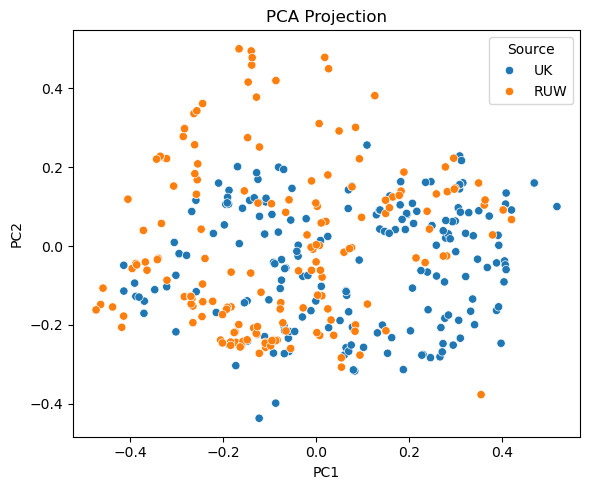

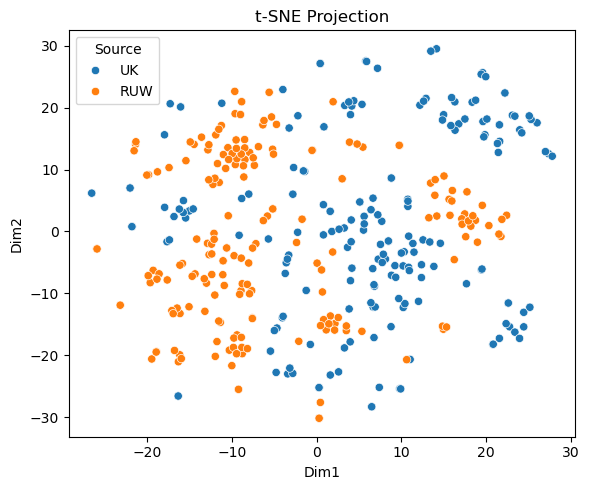

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

uk_sample = uk_df.sample(n=min(200, len(uk_df)), random_state=42).reset_index(drop=True)
ruw_sample = ruw_df.sample(n=min(200, len(ruw_df)), random_state=42).reset_index(drop=True)

uk_vectors = np.array([uk_embeddings[i] for i in uk_sample.index])
ruw_vectors = np.array([ruw_embeddings[i] for i in ruw_sample.index])

X = np.vstack([uk_vectors, ruw_vectors])
y = ['UK'] * len(uk_vectors) + ['RUW'] * len(ruw_vectors)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
X_tsne = tsne.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Source'] = y

tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Source'] = y

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Source')
plt.title("PCA Projection")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Source')
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()


In [12]:
uk_df.columns

Index(['source', 'uk_title', 'segment_type', 'user', 'timestamp', 'uk_text',
       'ru_text', 'ru_title', 'similarity', 'is_reverted', 'text_length',
       'pro_kremlin_score', 'pro_ukrainian_score'],
      dtype='object')

In [14]:
ruw_df.columns

Index(['source', 'ruw_title', 'segment_type', 'user', 'timestamp', 'ruw_text',
       'ru_text', 'ru_title', 'similarity', 'is_reverted', 'text_length'],
      dtype='object')

2025-04-21 08:18:22 INFO: Downloaded file to /home/jovyan/stanza_resources/resources.json
2025-04-21 08:18:22 INFO: Downloading default packages for language: ru (Russian) ...
2025-04-21 08:18:23 INFO: File exists: /home/jovyan/stanza_resources/ru/default.zip
2025-04-21 08:18:29 INFO: Finished downloading models and saved to /home/jovyan/stanza_resources


2025-04-21 08:18:29 INFO: Downloaded file to /home/jovyan/stanza_resources/resources.json
2025-04-21 08:18:29 INFO: Downloading default packages for language: ru (Russian) ...
2025-04-21 08:18:31 INFO: File exists: /home/jovyan/stanza_resources/ru/default.zip
2025-04-21 08:18:36 INFO: Finished downloading models and saved to /home/jovyan/stanza_resources


2025-04-21 08:18:37 INFO: Downloaded file to /home/jovyan/stanza_resources/resources.json
2025-04-21 08:18:37 INFO: Downloading default packages for language: uk (Ukrainian) ...
2025-04-21 08:18:37 INFO: File exists: /home/jovyan/stanza_resources/uk/default.zip
2025-04-21 08:18:41 INFO: Finished downloading models and saved to /home/jovyan/stanza_resources
2025-04-21 08:18:41 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-21 08:18:41 INFO: Downloaded file to /home/jovyan/stanza_resources/resources.json
2025-04-21 08:18:41 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |

2025-04-21 08:18:41 INFO: Using device: cuda
2025-04-21 08:18:41 INFO: Loading: tokenize
2025-04-21 08:18:41 INFO: Loading: pos
2025-04-21 08:18:43 INFO: Loading: lemma
2025-04-21 08:18:44 INFO: Done loading processors!
2025-04-21 08:18:44 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-21 08:18:44 INFO: Downloaded file to /home/jovyan/stanza_resources/resources.json
2025-04-21 08:18:44 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package     |
---------------------------
| tokenize  | iu          |
| mwt       | iu          |
| pos       | iu_charlm   |
| lemma     | iu_nocharlm |

2025-04-21 08:18:44 INFO: Using device: cuda
2025-04-21 08:18:44 INFO: Loading: tokenize
2025-04-21 08:18:44 INFO: Loading: mwt
2025-04-21 08:18:44 INFO: Loading: pos
2025-04-21 08:18:46 INFO: Loading: lemma
2025-04-21 08:18:46 INFO: Done loading processors!
/tmp/ipykernel_991/2747545806.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=krem, x='source', y='pro_kremlin_score', palette=[pro_kremlin_color])
/tmp/ipykernel_991/2747545806.py:82: UserWarning: 
The palette list has fewer values (1) than ne

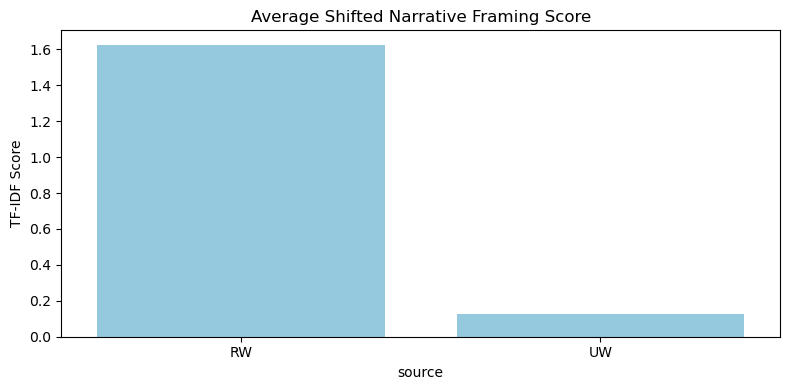

/tmp/ipykernel_991/2747545806.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ukr, x='source', y='pro_ukrainian_score', palette=[pro_ukrainian_color])
/tmp/ipykernel_991/2747545806.py:92: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=ukr, x='source', y='pro_ukrainian_score', palette=[pro_ukrainian_color])


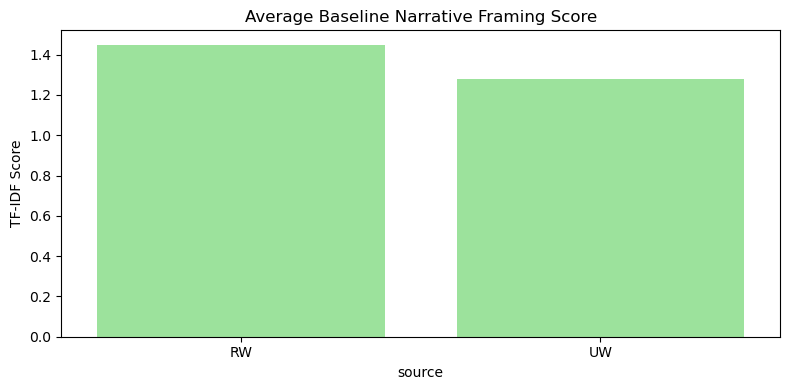

In [101]:
import stanza
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re

stanza.download("ru")

stanza.download("ru")
stanza.download("uk")

nlp_ru = stanza.Pipeline(lang='ru', processors='tokenize,pos,lemma')
nlp_uk = stanza.Pipeline(lang='uk', processors='tokenize,mwt,pos,lemma')


def lemmatize_ru(text):
    text = re.sub(r"[^\w\s]", "", str(text).lower())
    doc = nlp_ru(text)
    return " ".join([word.lemma for sent in doc.sentences for word in sent.words])

def lemmatize_uk(text):
    text = re.sub(r"[^\w\s]", "", str(text).lower())
    doc = nlp_uk(text)
    return " ".join([word.lemma for sent in doc.sentences for word in sent.words])


uk_df = pd.read_csv("uk_ru_high_similarity_matches.csv")
ruw_df = pd.read_csv("ruw_ru_high_similarity_matches.csv")

ruw_df['lemmas'] = ruw_df['ruw_text'].apply(lemmatize_ru)
uk_df['lemmas'] = uk_df['uk_text'].apply(lemmatize_uk)

pro_kremlin_frame_ru = {
    "освобождение", "специальная", "военная", "операция", "защита", "федеральный", "субъект",
    "интеграция", "референдум", "народный", "республика", "воссоединение", "присоединение", "днр", "лнр"
}
pro_ukrainian_frame_ru = {
    "вторжение", "оккупация", "агрессия", "атака", "аннексия", "война",
    "обстрел", "авиаудар", "захват", "террорист"
}

pro_kremlin_frame_ua = {
    "спеціальна операція", "федеральний", "суб’єкт",
    "інтеграція", "референдум", "народна республіка", "возз'єднання", "приєднання", "днр", "лнр"
}
pro_ukrainian_frame_ua = {
    "вторгнення", "окупація", "агресія", "атака", "анексія", "війна",
    "обстріл", "авіаудар", "захоплення", "терористи"
}

def frame_tfidf_score(texts, frame_words):
    vectorizer = TfidfVectorizer(vocabulary=frame_words, use_idf=True, norm=None)
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix.sum(axis=1).A1

ruw_df['pro_kremlin_score'] = frame_tfidf_score(ruw_df['lemmas'], pro_kremlin_frame_ru)
ruw_df['pro_ukrainian_score'] = frame_tfidf_score(ruw_df['lemmas'], pro_ukrainian_frame_ru)
uk_df['pro_kremlin_score'] = frame_tfidf_score(uk_df['lemmas'], pro_kremlin_frame_ua)
uk_df['pro_ukrainian_score'] = frame_tfidf_score(uk_df['lemmas'], pro_ukrainian_frame_ua)

uk_df['source'] = 'UW'
ruw_df['source'] = 'RW'

combined = pd.concat([
    uk_df[['source', 'pro_kremlin_score', 'pro_ukrainian_score']],
    ruw_df[['source', 'pro_kremlin_score', 'pro_ukrainian_score']]
])

krem = combined.groupby('source')['pro_kremlin_score'].mean().reset_index()
ukr = combined.groupby('source')['pro_ukrainian_score'].mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns


pro_kremlin_color = "skyblue"
pro_ukrainian_color = "lightgreen"


plt.figure(figsize=(8, 4))
sns.barplot(data=krem, x='source', y='pro_kremlin_score', palette=[pro_kremlin_color])
plt.title("Average Shifted Narrative Framing Score")
plt.ylabel("TF-IDF Score")
plt.tight_layout()


plt.savefig("pro_kremlin_framing_score.pdf", format='pdf')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=ukr, x='source', y='pro_ukrainian_score', palette=[pro_ukrainian_color])
plt.title("Average Baseline Narrative Framing Score")
plt.ylabel("TF-IDF Score")
plt.tight_layout()
plt.savefig("pro_ukrainian_framing_score.pdf", format='pdf')


plt.show()


/tmp/ipykernel_991/3792793259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=krem, x='source', y='pro_kremlin_score', palette=color_map)


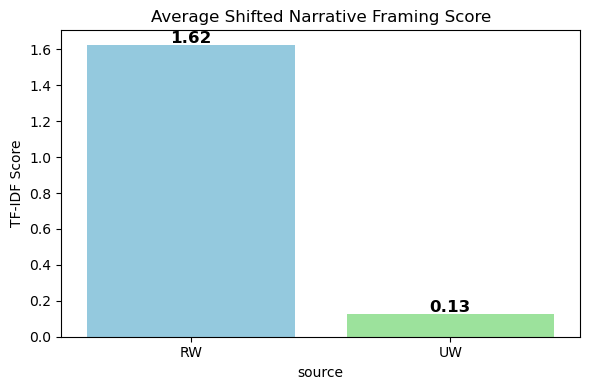

/tmp/ipykernel_991/3792793259.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=ukr, x='source', y='pro_ukrainian_score', palette=color_map)


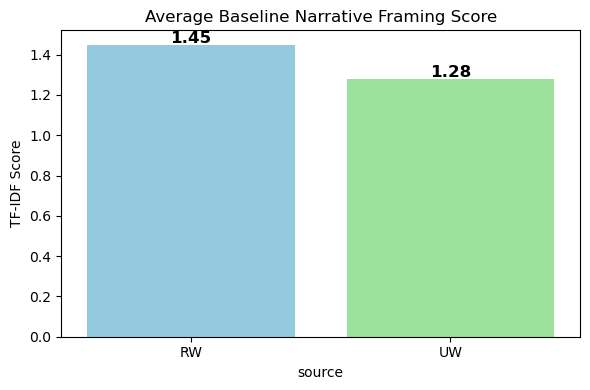

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

color_map = {'RW': 'skyblue', 'UW': 'lightgreen'}

plt.figure(figsize=(6, 4))
ax1 = sns.barplot(data=krem, x='source', y='pro_kremlin_score', palette=color_map)
plt.title("Average Shifted Narrative Framing Score")
plt.ylabel("TF-IDF Score")
plt.tight_layout()

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black', 
                 xytext=(0, -1), textcoords='offset points')

plt.savefig("pro_kremlin_framing_score.pdf", format='pdf')

plt.show()


plt.figure(figsize=(6, 4))
ax2 = sns.barplot(data=ukr, x='source', y='pro_ukrainian_score', palette=color_map)
plt.title("Average Baseline Narrative Framing Score")
plt.ylabel("TF-IDF Score")
plt.tight_layout()


for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black', 
                 xytext=(0, -1), textcoords='offset points')


plt.savefig("pro_ukrainian_framing_score.pdf", format='pdf')
plt.show()


In [67]:
threshold = uk_df['pro_kremlin_score'].quantile(0.95) 
high_kremlin_uk_texts = uk_df[uk_df['pro_kremlin_score'] > threshold]
 
high_kremlin_uk_texts_top = high_kremlin_uk_texts[['uk_text', 'pro_kremlin_score']]


print(len(high_kremlin_uk_texts_top))


6


In [71]:
threshold = ruw_df['pro_kremlin_score'].quantile(0.95) 
high_kremlin_ruw_texts = ruw_df[ruw_df['pro_kremlin_score'] > threshold]
 
high_kremlin_ruw_texts_top = high_kremlin_ruw_texts[['ruw_text', 'pro_kremlin_score']]


print(len(high_kremlin_ruw_texts_top))


98


In [69]:
for index, row in high_kremlin_uk_texts_top.iterrows():
    print(f"Text {index+1}:")
    print(f"Pro-Kremlin Score: {row['pro_kremlin_score']:.4f}")
    print(f"Text: {row['uk_text']}")
    print("-" * 80) 

Text 79:
Pro-Kremlin Score: 5.7985
Text: ['З 2014 року місто знаходиться пiд контролем ЛНР']
--------------------------------------------------------------------------------
Text 131:
Pro-Kremlin Score: 12.4080
Text: Підтримує інтеграцію з C++ Builder, Delphi, Microsoft Visual Studio, Oracle SQL, Macromedia ColdFusion і Watcom C/C++ . -> Підтримує інтеграцію з C++ Builder, Delphi, Microsoft Visual Studio, Oracle SQL, Macromedia ColdFusion і Watcom C/C++. Підтримує велику кількість популярних мов програмування — Delphi, FORTRAN-77, Python, Batch, SQL, Matlab, TCL, REBOL, ColdFusion, COBOL, DBase, Verilog, C#, ASP, Ada, Aspect, Progress, C/C++, Java, JavaScript, AutoLISP, Modula-2, PERL, HTMLScript, PERLScript, BASIC, VB, ASM, CSS, PL/SQL, CSV, DataFlex, HTML, VHDL, Scilab тощо. -> Підтримує велику кількість популярних мов програмування — Delphi, FORTRAN-77, Python, Batch, SQL, Matlab, Tcl, REBOL, ColdFusion, COBOL, DBase, Verilog, C#, ASP, Ada, Aspect, Progress, C/C++, Java, JavaScript,

In [73]:
for index, row in high_kremlin_ruw_texts_top.iterrows():
    print(f"Text {index+1}:")
    print(f"Pro-Kremlin Score: {row['pro_kremlin_score']:.4f}")
    print(f"Text: {row['ruw_text']}")
    print("-" * 80) 

Text 64:
Pro-Kremlin Score: 11.8378
Text: ['В тот же день город перешёл под контроль ЛНР.', 'Город интенсивно обстреливается российской артиллерией', 'По данным Луганской областной военно-гражданской администрации российские войска продвинулись, но город не захватили', 'Официальный представитель Минобороны РФ Игорь Конашенков на утреннем брифинге 18 марта 2022 года сообщил, что «в настоящее время подразделениями Луганской народной республики уничтожаются разрозненные группы националистов на южных окраинах освобожденного населенного пункта Рубежное».', 'Глава областной военно-гражданской администрации Сергей Гайдай сообщил: "Если раньше выборочно был обстрел, то сегодня они квадрат за квадратом уничтожают как Рубежное, так и Северодонецк, другие населенные пункты"', 'Враг продвинулся в Рубежном Луганской области – глава ОВА', 'По данным Министерства обороны РФ, 12 марта 2022 года войска Луганской народной республики блокировали Рубежное, а 17 марта МО РФ сообщило о ведении войсками ЛНР 

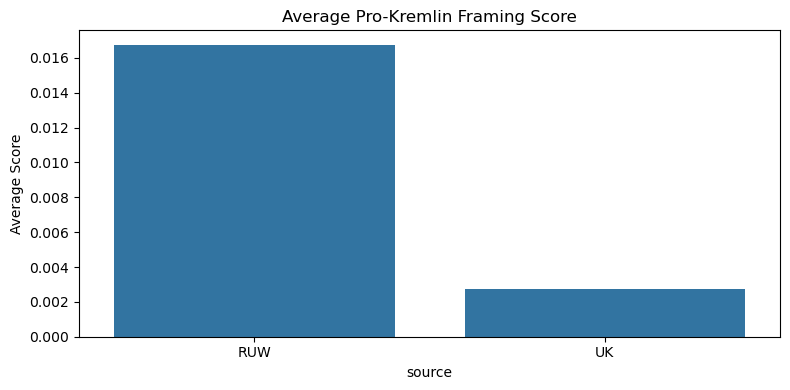

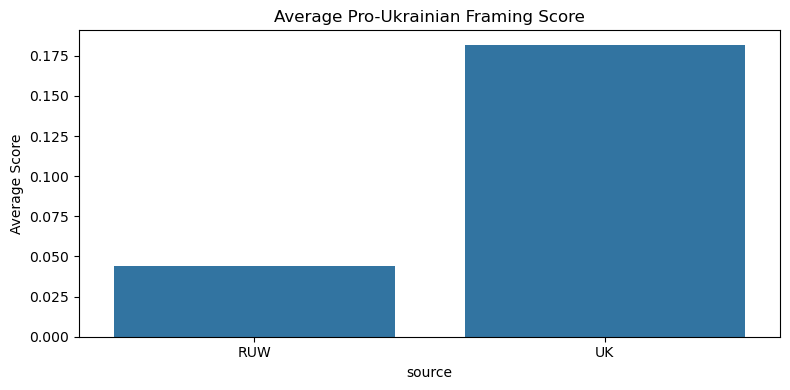

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

uk_df = pd.read_csv("uk_ru_high_similarity_matches.csv")
ruw_df = pd.read_csv("ruw_ru_high_similarity_matches.csv")

pro_kremlin_frame_ru = {
    "освобождение", "специальная операция", "защита", "федеральный", "субъект",
    "интеграция", "референдум", "народная республика", "воссоединение", "присоединение", "днр", "лнр"
}
pro_ukrainian_frame_ru = {
    "вторжение", "оккупация", "агрессия", "атака", "аннексия", "война",
    "обстрел", "авиаудар", "захват", "террористи"
}
pro_kremlin_frame_ua = {
    "визволення", "спеціальна операція", "захист", "федеральний", "суб’єкт",
    "інтеграція", "референдум", "народна республіка", "возз'єднання", "приєднання", "днр", "лнр"
}
pro_ukrainian_frame_ua = {
    "вторгнення", "окупація", "агресія", "атака", "анексія", "війна",
    "обстріл", "авіаудар", "захоплення", "терористи"
}

def detect_frames(text, frame_words):
    tokens = set(str(text).lower().split())
    return len(tokens & frame_words)

uk_df['pro_kremlin_score'] = uk_df['uk_text'].apply(lambda x: detect_frames(x, pro_kremlin_frame_ua))
uk_df['pro_ukrainian_score'] = uk_df['uk_text'].apply(lambda x: detect_frames(x, pro_ukrainian_frame_ua))
ruw_df['pro_kremlin_score'] = ruw_df['ruw_text'].apply(lambda x: detect_frames(x, pro_kremlin_frame_ru))
ruw_df['pro_ukrainian_score'] = ruw_df['ruw_text'].apply(lambda x: detect_frames(x, pro_ukrainian_frame_ru))

uk_df['source'] = 'UK'
ruw_df['source'] = 'RUW'

combined = pd.concat([
    uk_df[['source', 'pro_kremlin_score', 'pro_ukrainian_score']],
    ruw_df[['source', 'pro_kremlin_score', 'pro_ukrainian_score']]
])

krem = combined.groupby('source')['pro_kremlin_score'].mean().reset_index()
ukr = combined.groupby('source')['pro_ukrainian_score'].mean().reset_index()


# Each score is a count of how many words from a framing word set (e.g., pro-Kremlin or pro-Ukrainian) are found in a given text segment.
plt.figure(figsize=(8, 4))
sns.barplot(data=krem, x='source', y='pro_kremlin_score')
plt.title("Average Pro-Kremlin Framing Score")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=ukr, x='source', y='pro_ukrainian_score')
plt.title("Average Pro-Ukrainian Framing Score")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()
